(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


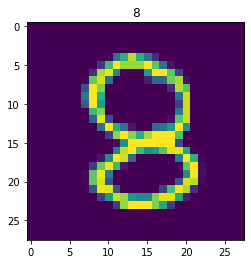

In [2]:
import numpy as np
import matplotlib.pyplot as plt

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']
test_y=np.load('prediction.npy')
# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[0, 0])
plt.title(data_y[0])
plt.show()

In [2]:
import sys
import torch
from torch import nn
import torchvision

Following the slides, the data preparation steps are: 
* download data
* featurization
* split in train and test data( 80/20 should be sufficient for the MNIST)
* Shuffle data sets
* Center data: subtract mean over all samples from each sample

Load The training data and calculate the mean and standart deviation to further feed to transform argument to normalize training data

In [51]:
class LoadMNIST(torch.utils.data.dataset.Dataset):
    def __init__(self, data_x, data_y, transform=None):
        self.data = data_x
        self.labels = data_y
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[index]
        labels = self.labels[index]
        if self.transform:     
            data = self.transform(data)
        return data, labels

    def __len__(self):
        return len(self.labels)
    

In [52]:
data = LoadMNIST(data_x,data_y)

split into train and data

In [53]:
validation_part = 0.2
split = round(len(data)*validation_part)

In [54]:
train_data,valid_data = torch.utils.data.random_split(data, [len(data)-split, split])

calculate mean and standart deviation of the training data to normalize in the next step


In [55]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean_t, std_t = torch.mean(x), torch.std(x)
mean_t, std_t

(tensor(33.6598), tensor(78.9123))

In [57]:
x.shape

torch.Size([16000, 1, 28, 28])

Now we compose a transform that normalizes our train and validation data by mean and standart deviation and also transforms it into tensor

In [58]:
train_data.dataset.transform  = torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(mean = (mean_t),std = (std_t))
])
valid_data.dataset.transform  = torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(mean = (mean_t),std = (std_t))
])

#transforms.Normalize((0.1307,), (0.3081,))

In [50]:
train_data.dataset.transform

Compose(
    ToTensor()
    Normalize(mean=33.68040466308594, std=78.93372344970703)
)

make batches of the data and shuffle it

In [63]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle = True)

In [64]:
images, labels = iter(train_loader).next()
print(images[0][0], images.shape)

tensor([[-0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265,
         -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265,
         -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265, -0.4265,
         -0.4265, -0.4265, -0.4265, -0.4265]]) torch.Size([64, 28, 1, 28])


In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cpu device


Define the architecture of the neural network

In [66]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.body = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=1024),
            nn.Sigmoid(),
            nn.Linear(1024,10)
        )

    def forward(self, x):
        b, c, d, e = x.shape
        x = x.reshape([b, 28*28])
        return self.body(x)

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (body): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [35]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
model = Net().to(device)

define the loss function and the optimizer. I will use Cross entropy loss and stochastic gradient descent

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

define the training function

In [68]:
def train(data, model,  loss_fn, optimizer, max_epochs):
    model.train()
    losses = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            yhat = torch.argmax(output, dim=1)

            samples_total += len(y)
            samples_correct += torch.sum(yhat == y)
            losses.append(loss.item())
            if batch_idx % 50 == 0:
                acc = float(samples_correct) / float(samples_total)
                sys.stdout.write(f'\rEpoch: {epoch+1}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f} Acc: {acc:.2%}')
    return losses

The validation

In [69]:
def validate(model, data,loss_fn):
    criterion = loss_fn
    losses = []
    correct_samples = 0
    total_samples = 0
    for x, y in data:
        x, y = x.to(device), y.to(device)
        output = model(x)
        
        loss = criterion(output, y)
        yhat = torch.argmax(output, dim=1)
        losses.append(loss.item())
        correct_samples += torch.sum(yhat == y)
        total_samples += len(y)

    mean_losses = np.mean(losses)
    acc = float(correct_samples) / float(total_samples)
    print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

    return mean_losses, acc

In [70]:
losses = train((train_loader, validation_loader),model, loss_fn, optimizer, max_epochs=10)

Epoch: 10/10 Step: 200/250 Loss: 0.000004 Acc: 98.55%

In [71]:
validate(model, validation_loader, loss_fn)

Validation complete! Validation loss: 0.479517, Validation accuracy: 95.03%


(0.4795167742274879, 0.95025)

Make a prediction for the test set

In [72]:
input_test = (torch.from_numpy(test_x)-mean_t)/std_t

In [73]:
prediction = model(input_test)

translate logits into the classes

In [74]:
predictions = torch.argmax(prediction,dim=1)

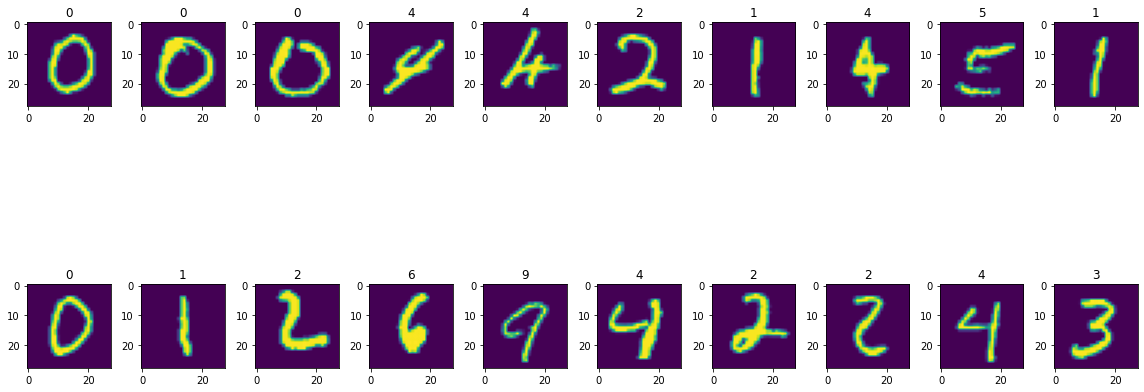

In [3]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(2, 10, figure = fig)
row = 0
mc=0
for col in range(0,20):
    if col ==10:
        row+=1
        mc=10
    ax= fig.add_subplot(gs[row, col-mc])
    ind = np.random.randint(low = 0,high = test_x.shape[0])
    ax.imshow(test_x[ind,0])
    ax.set_title(test_y[ind])

fig.tight_layout()
plt.show()

In [4]:
test_y[0:10]

array([9, 7, 3, 7, 9, 5, 2, 9, 2, 6])

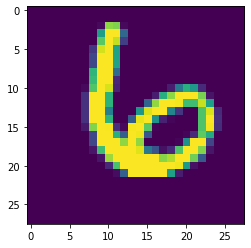

In [7]:
plt.imshow(test_x[9,0])